In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv")
df.columns

Index(['FullDate', 'Tmax', 'SysLoad', 'GasPrice', 'ElecPrice'], dtype='object')

In [ ]:
Elecprice_df = df.drop(columns=['Tmax', 'SysLoad', 'GasPrice'])

In [ ]:
#check for missing values 
Elecprice_df.isnull().values.any()

False

In [ ]:
Elecprice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   ElecPrice  92016 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
Elecprice_df["FullDate"] = pd.to_datetime(Elecprice_df["FullDate"]) #convert column to datetime
Elecprice_df.set_index("FullDate", inplace= True)

Text(0, 0.5, 'Electricity Price')

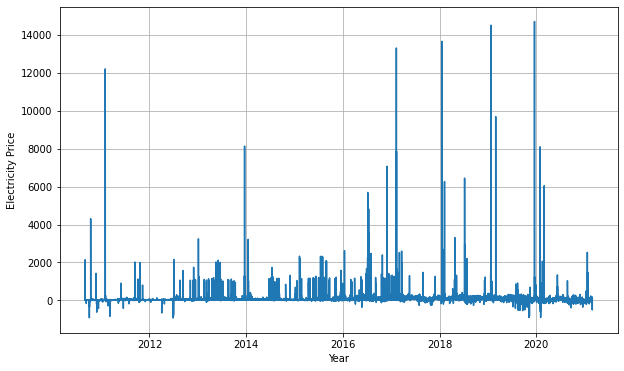

In [ ]:
plt.figure(figsize=( 10 , 6 ))

plt.plot(Elecprice_df.index, Elecprice_df.ElecPrice)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Electricity Price')

In [ ]:
Elecprice_df.head()

,ElecPrice
FullDate,
2010-09-01,2751.700
2010-09-02,570.810
2010-09-03,504.975
2010-09-04,502.275
2010-09-05,500.555


In [ ]:
#Downsample to quarterly data points 
Elecprice_df = Elecprice_df.resample('D').sum()

In [ ]:
MA = Elecprice_df['ElecPrice'].rolling(12).mean()

Text(0, 0.5, 'Electricity Price')

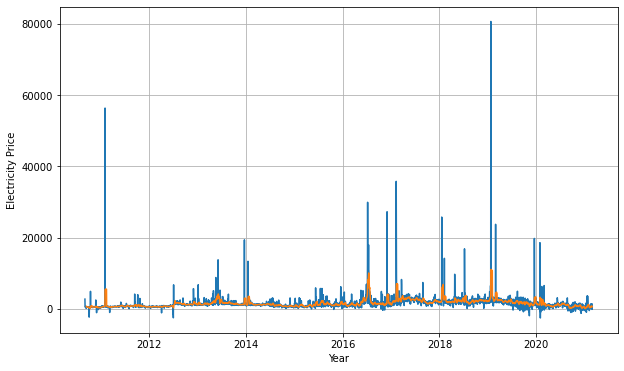

In [ ]:
plt.figure(figsize=( 10, 6))

plt.plot(Elecprice_df.index, Elecprice_df.ElecPrice)
plt.plot(MA)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Electricity Price')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(Elecprice_df.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

NotImplementedError: ignored

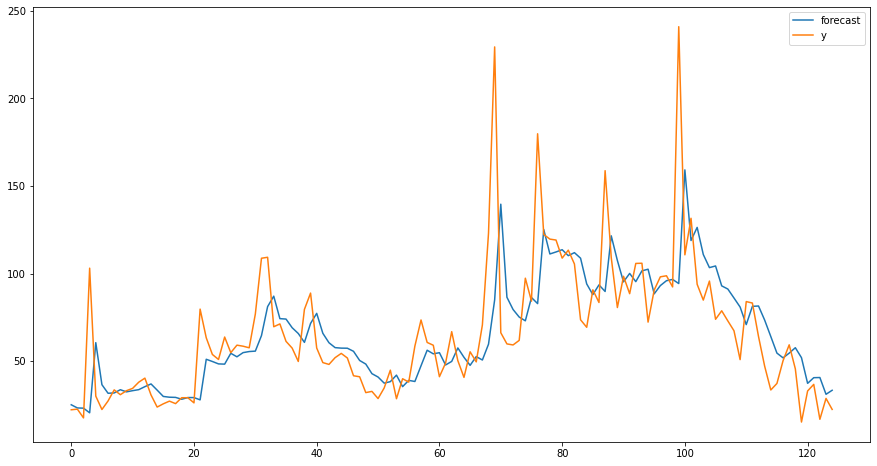

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = Elecprice_df[:80]
test = Elecprice_df[80:]

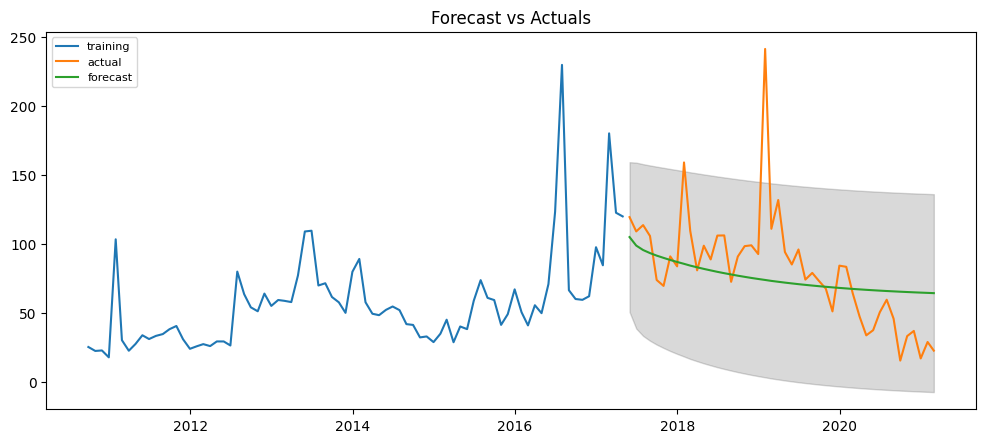

In [ ]:
# Build Model
model = ARIMA(train, order=(2, 0, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(46, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
test['Forecast'] = fc
test.head()

<ipython-input-302-8db524e36a00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = fc


,ElecPrice,Forecast
FullDate,,
2017-05-31,119.154577,104.708985
2017-06-30,108.823389,98.549443
2017-07-31,113.385739,95.320282
2017-08-31,105.484839,93.106407
2017-09-30,73.612771,91.282912


In [ ]:

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    me = np.mean(forecast - actual)            
    mae = np.mean(np.abs(forecast - actual))   
    mpe = np.mean((forecast - actual)/actual)  
    rmse = np.mean((forecast - actual)**2)**.5  
    corr = np.corrcoef(forecast, actual)[0,1]  
                      
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

forecast_accuracy(test.Forecast, test.ElecPrice)

{'mape': 0.44783028681034703,
 'me': -5.605149387926746,
 'mae': 24.24091053794047,
 'mpe': 0.20688712817064236,
 'rmse': 35.720688256629934,
 'corr': 0.5087955255626373}

Around 44.78% MAPE implies the model is about 55.22% accurate in predicting the next 46 observations.

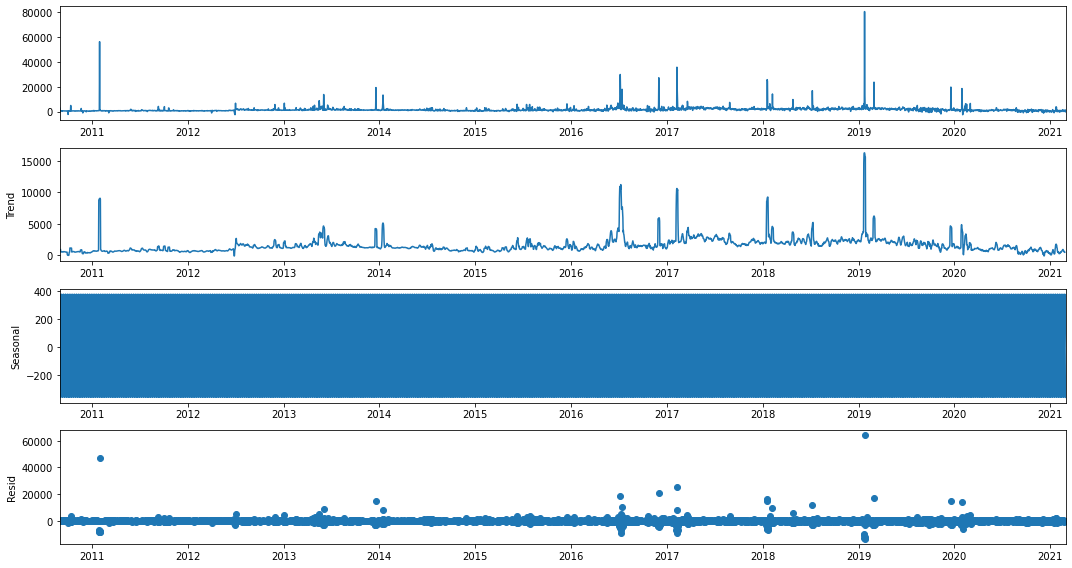

In [ ]:
import statsmodels.api as sm 
from pylab import rcParams

rcParams['figure.figsize'] = 15 , 8 

decompose_series = sm.tsa.seasonal_decompose(Elecprice_df, model= 'additive') 
decompose_series.plot() 
plt.show()

,ElecPrice
FullDate,
2010-09-01,2751.700
2010-09-02,570.810
2010-09-03,504.975
2010-09-04,502.275
2010-09-05,500.555
...,...
2021-02-24,634.770
2021-02-25,577.515
2021-02-26,1445.495


In [ ]:
# ADF test for stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(Elecprice_df.ElecPrice) 
print(f'ADF Statistic: {adf_result[0]}') 
print(f'p-value: {adf_result[1]}') 
print(f'No. of lags used: {adf_result[2]}') 
print(f'No. of observations used : {adf_result[3]}') 
print('Critical Values:')
 
for k, v in adf_result[4].items():
    print(f'{k} : {v}')

ADF Statistic: -8.269053866873803
p-value: 4.848817773711633e-13
No. of lags used: 20
No. of observations used : 3813
Critical Values:
1% : -3.432066157296446
5% : -2.8622983040036005
10% : -2.5671736550459663


P-Value is less than the critical value at 5% 
significance level, and the ADF statistic is less that any of the critical values. Which means the serie is non-stationary. (P-Value < 5%) reject H0.

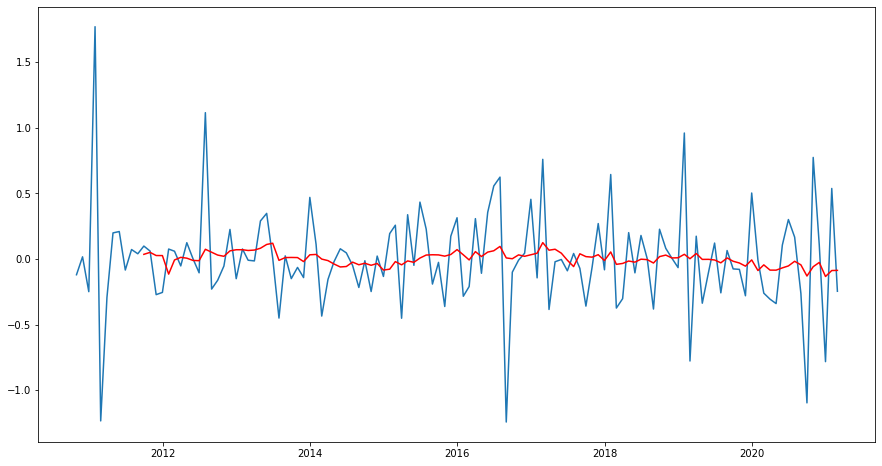

In [ ]:
#Convert the serie to stationary by removing trend and seasonality 
#Transformation and Differencing

df_log = np.log(Elecprice_df)
df_diff = df_log.diff(periods= 1)

#Plot stationary series
plt.plot(df_diff.index, df_diff.ElecPrice, '-') 
plt.plot(df_diff.ElecPrice.rolling(12).mean(), color= 'red')

In [ ]:
df_diff.dropna(inplace=True)

In [ ]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2010-10-31 to 2021-02-28
Freq: M
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ElecPrice  125 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


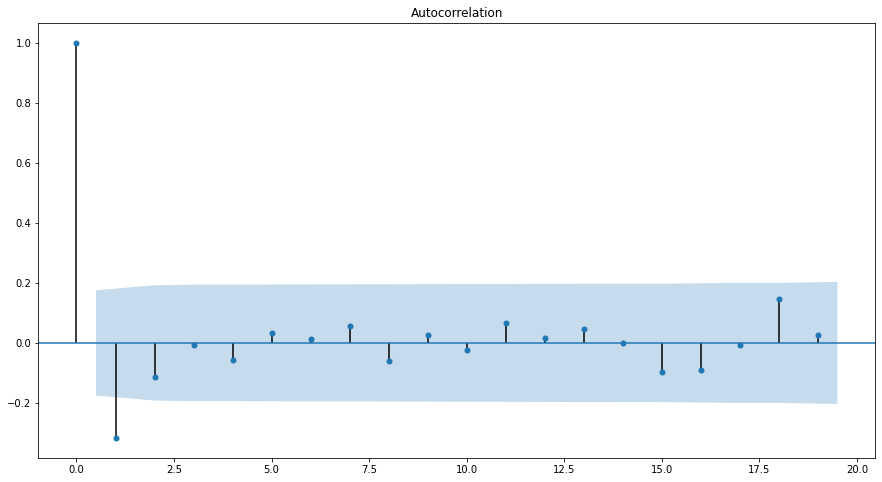

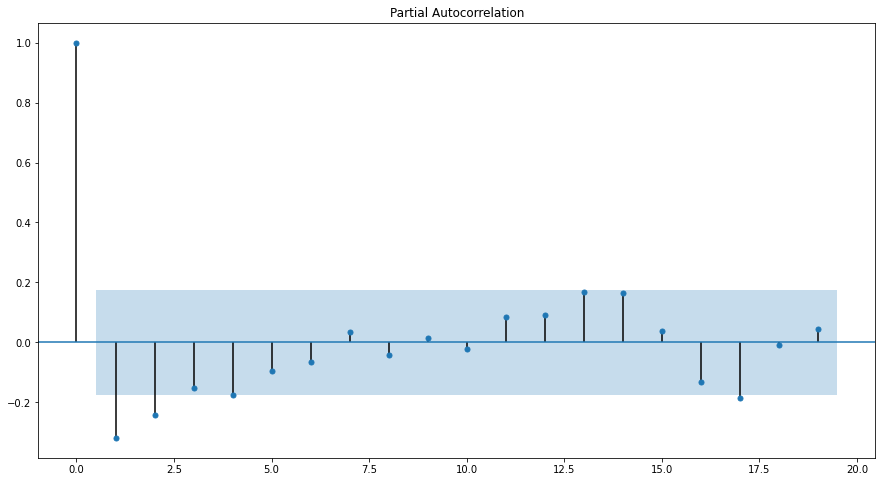

In [ ]:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

#ACF 
plot_acf(df_diff, lags= range(0,20)) 
plt.show() 

#PACF 
plot_pacf(df_diff, lags= range(0,20)) 
plt.show()

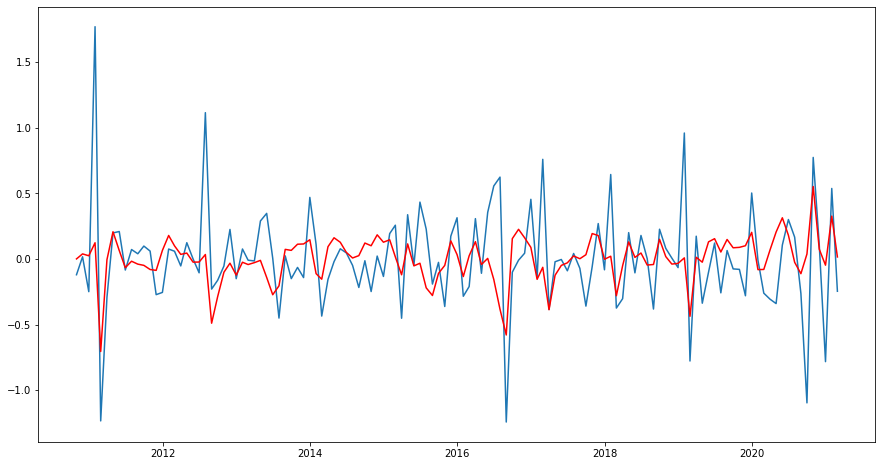

In [ ]:
#AR, MA and ARIMA(p,d,q) 
from statsmodels.tsa.arima_model import ARIMA

AR_model = ARIMA(df_diff, order=(2,0,1))
AR_model_results = AR_model.fit()

plt.plot(df_diff.ElecPrice)
plt.plot(AR_model_results.fittedvalues, color= 'red')

In [ ]:
Elecprice_df.reset_index(inplace=True)
Elecprice_df.head()

,FullDate,ElecPrice
0,2010-09-30,25.075896
1,2010-10-31,22.223629
2,2010-11-30,22.575944
3,2010-12-31,17.585753
4,2011-01-31,103.094603


### Prophet

In [ ]:
Elecprice_df = Elecprice_df.rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y" })

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph28s_igb/02v47jxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph28s_igb/2g31rgyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14506', 'data', 'file=/tmp/tmph28s_igb/02v47jxu.json', 'init=/tmp/tmph28s_igb/2g31rgyj.json', 'output', 'file=/tmp/tmph28s_igb/prophet_modelvai9pqfk/prophet_model-20230119001736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:17:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


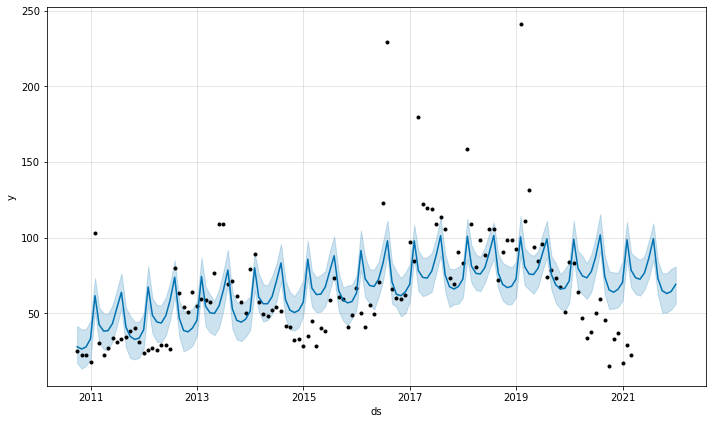

In [ ]:
from prophet import Prophet

model = Prophet(interval_width=0.3)
model.fit(Elecprice_df)
 
#predict for the next 10 months 
future = model.make_future_dataframe(periods= 10 , freq= 'M') 
forecast = model.predict(future) 
forecast.head() 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']] 

#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries 
model.plot(forecast)
plt.show()

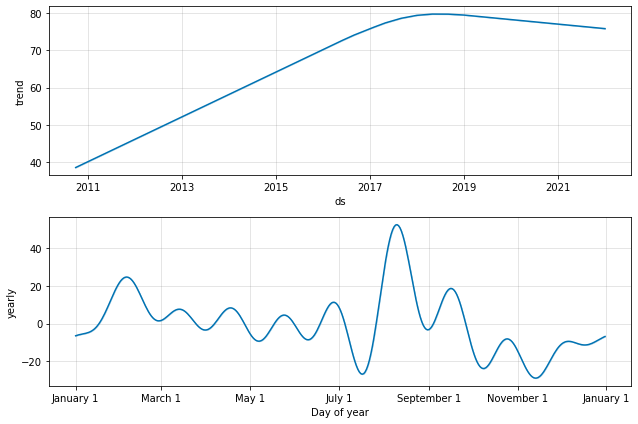

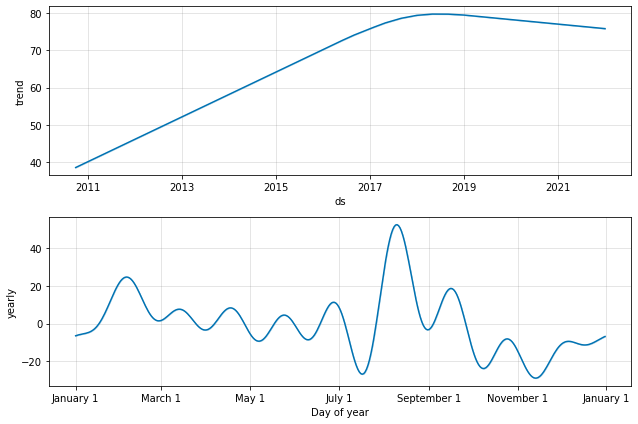

In [ ]:
model.plot_components(forecast)

### Automated ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(Elecprice_df.values, start_p=1, start_q=1,
                      test='adf',       # adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1203.606, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1235.276, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1218.335, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1205.388, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1233.276, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1205.525, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1205.565, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1204.144, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1216.294, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1207.380, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1201.606, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1203.388, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1216.335, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1203.526, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]          

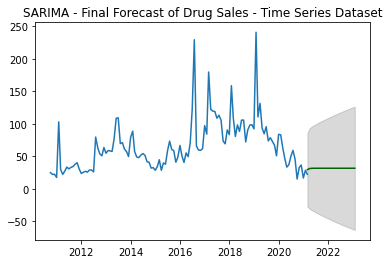

In [ ]:
# Forecast
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(Elecprice_df.index[-1], periods= n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(Elecprice_df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

### Quiz part 1

In [ ]:
df=pd.read_csv("https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv")
df.shape, df.columns

((92016, 5),
 Index(['FullDate', 'Tmax', 'SysLoad', 'GasPrice', 'ElecPrice'], dtype='object'))

In [ ]:
df["FullDate"] = pd.to_datetime(df["FullDate"]) #convert column to date
df.set_index("FullDate", inplace= True)

In [ ]:
#Downsample data points 
daily_df = df.resample('D').sum()
daily_df.shape

(3834, 4)

In [ ]:
daily_df.reset_index(inplace=True)
daily_df = daily_df.drop(columns=['Tmax', 'SysLoad', 'GasPrice'])
daily_df = daily_df.rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y" })

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
daily_train = daily_df[:2757]
daily_test = daily_df[2757:]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ja5tkwp/f3pyfjd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ja5tkwp/y_8mhila.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58073', 'data', 'file=/tmp/tmp3ja5tkwp/f3pyfjd2.json', 'init=/tmp/tmp3ja5tkwp/y_8mhila.json', 'output', 'file=/tmp/tmp3ja5tkwp/prophet_modelr4wixqbf/prophet_model-20230119234624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


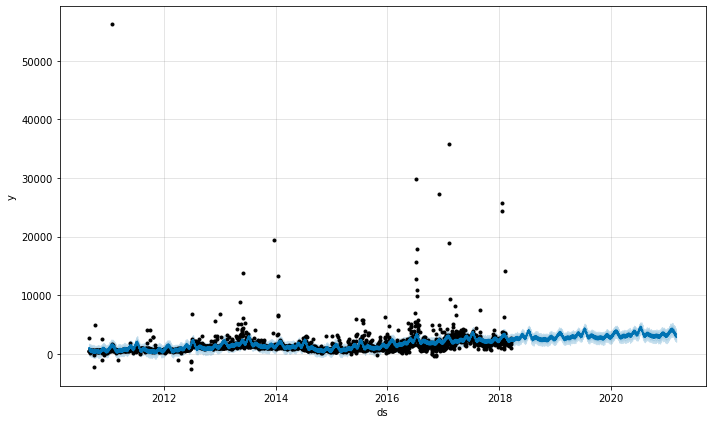

In [ ]:
from prophet import Prophet

model = Prophet(interval_width=0.3)
model.fit(daily_train)
 
#predict for the next 10 months 
future = model.make_future_dataframe(periods= 1077 , freq= 'D') 
forecast = model.predict(future) 
forecast.head() 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']] 

#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries 
model.plot(forecast)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(daily_test.y, forecast["yhat"][2757:])
mae = mean_absolute_error(daily_test.y, forecast["yhat"][2757:])
mape = np.mean(np.abs((daily_test.y - forecast["yhat"][2757:]) / daily_test.y)) * 100

print('MSE:', mse)
print('MAE:', mae)
print('MAPE:', mape)

MSE: 10291665.047393445
MAE: 1731.9703063637687
MAPE: 544.7254323999416


In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='700 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 10 forecasts with cutoffs between 2012-10-11 00:00:00 and 2017-03-19 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk0a6ja8p/euhxfg9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk0a6ja8p/_plqkbsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29230', 'data', 'file=/tmp/tmpk0a6ja8p/euhxfg9a.json', 'init=/tmp/tmpk0a6ja8p/_plqkbsc.json', 'output', 'file=/tmp/tmpk0a6ja8p/prophet_model53uguz82/prophet_model-20230119181221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk0a6ja8p/v4vptcyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk0a6ja8p/adf9omsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(df_cv.y, df_cv.yhat)
mae = mean_absolute_error(df_cv.y, df_cv.yhat)
mape = np.mean(np.abs((df_cv.y - df_cv.yhat) / df_cv.y)) * 100

print('MSE:', mse)
print('MAE:', mae)
print('MAPE:', mape)

MSE: 3589651.66623976
MAE: 965.236164614776
MAPE: 80.18511896906392


### Quiz part 2

In [ ]:
# ADF test for stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(daily_df.y) 
print(f'ADF Statistic: {adf_result[0]}') 
print(f'p-value: {adf_result[1]}') 
print(f'No. of lags used: {adf_result[2]}') 
print(f'No. of observations used : {adf_result[3]}') 
print('Critical Values:')
 
for k, v in adf_result[4].items():
    print(f'{k} : {v}')

ADF Statistic: -8.269053866873803
p-value: 4.848817773711633e-13
No. of lags used: 20
No. of observations used : 3813
Critical Values:
1% : -3.432066157296446
5% : -2.8622983040036005
10% : -2.5671736550459663


In [ ]:
daily_df.reset_index(inplace=True)
daily_df = daily_df.rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y", 'Tmax':'add1', 'SysLoad':'add2', 'GasPrice':'add3' })

In [ ]:
# Create Training and Test
daily_train = daily_df[:2757]
daily_test = daily_df[2757:]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ja5tkwp/8dg1__0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ja5tkwp/vi760i5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12469', 'data', 'file=/tmp/tmp3ja5tkwp/8dg1__0h.json', 'init=/tmp/tmp3ja5tkwp/vi760i5n.json', 'output', 'file=/tmp/tmp3ja5tkwp/prophet_modellr3pelsk/prophet_model-20230120000144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:01:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


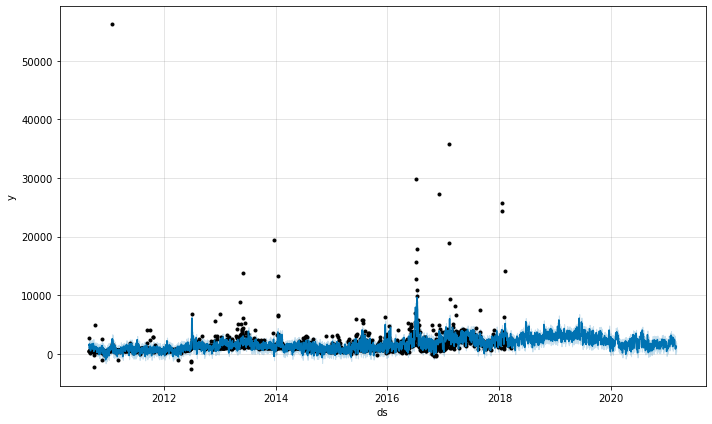

In [ ]:
from prophet import Prophet

model = Prophet(interval_width=0.3)

#add regressors
#model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')

#fit
model.fit(daily_train)
 
#predict for the next days 
future = model.make_future_dataframe(periods= 1077 , freq= 'D')

if(daily_df.shape[0] != future.shape[0]):
    raise ValueError("The size of the daily_df and future dataframe do not match")

future["add1"] = daily_df["add1"]
future["add2"] = daily_df["add2"]
future["add3"] = daily_df["add3"]
 
forecast = model.predict(future) 
forecast.head() 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']] 

#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries 
model.plot(forecast)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(daily_test.y, forecast["yhat"][2757:])
mae = mean_absolute_error(daily_test.y, forecast["yhat"][2757:])
mape = np.mean(np.abs((daily_test.y - forecast["yhat"][2757:]) / daily_test.y)) * 100

print('MSE:', mse)
print('MAE:', mae)
print('MAPE:', mape)

MSE: 7350646.574412731
MAE: 997.6384277950376
MAPE: 235.10628166869742


Ressources :
* https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting/notebook
* https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet